# 載入資料

In [1]:
!gdown --id '1N966AV3Gl_rCT1USbih-PMn9g_eEAp1O' --output taoyuan.csv

Downloading...
From: https://drive.google.com/uc?id=1N966AV3Gl_rCT1USbih-PMn9g_eEAp1O
To: /content/taoyuan.csv
100% 178M/178M [00:00<00:00, 215MB/s]


# 引入套件

In [2]:
%%capture
!pip install linearmodels
import linearmodels as plm

In [3]:
%%capture
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as sm
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

In [4]:
%%capture
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib.font_manager import fontManager

fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

# DataFrame

In [5]:
df = pd.read_csv('taoyuan.csv', parse_dates=['occur_datetime', 'start_datetime', 'end_datetime'])
df = df[['事故類別名稱', 'occur_datetime', 'start_datetime', 'end_datetime', '發生縣市名稱', 
         '發生市區鄉鎮名稱', '死亡人數_24小時內', '死亡人數_2_30日內', '受傷人數',
         '天候名稱', '光線名稱', '道路第1當事者_名稱', '速限_第1當事者', 
         '事故位置大類別名稱', '道路障礙_障礙物名稱', '事故類型及型態大類別名稱',
         '事故類型及型態子類別名稱', '肇因研判大類別名稱_主要', '肇因研判子類別名稱_主要',
         '當事者順位', '國籍', '當事者屬性別名稱', '當事者事故發生時年齡',
         '乘坐車輛的當事者區分_大類別名稱_車種','乘坐車輛的當事者區分_子類別名稱_車種',
         '受傷程度名稱', '行動電話_電腦或其他相類功能裝置名稱', '當事者行動狀態子類別名稱',
         '駕駛資格情形名稱', '駕駛執照種類大類別名稱', '駕駛執照種類子類別名稱',
         '飲酒情形名稱', '肇事逃逸類別名稱_是否肇逃']]
df.columns = ['acc_type', 'occur_datetime', 'start_datetime', 'end_datetime', 'county', 'town', 'death24_num', 'death30_num', 'hurt_num', 'weather', 'light', 'road_type', 'speed_limit', 'location_type', 'obstacle', 'accident_type', 'accident_subtype', 'cause_type', 'cause_subtype', 'party_order', 'nation', 'sex', 'age', 'vehicle_type', 'vehicle_subtype', 'injure_type', 'use_phone', 'action_type', 'driver_qualification', 'license_type', 'license_subtype', 'drink', 'hit_and_run']
df = df[df.party_order == 1].reset_index(drop=True)  # 僅考慮第1當事人

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Crash Level

In [6]:
# 總事故數
df['all_acc'] = ~df.acc_type.isna()

# 超速
df['cause_speed'] = ((df.cause_subtype=='未依規定減速') | (df.cause_subtype=='超速失控'))

# 警方到場花費時間
df['time_for_arrival'] = df.start_datetime - df.occur_datetime
df['time_for_arrival'] = df['time_for_arrival'] / np.timedelta64(1, 's') / 60

# 事故排除花費時間
df['time_for_solve'] = df.end_datetime - df.occur_datetime
df['time_for_solve'] = df['time_for_solve'] / np.timedelta64(1, 's') / 60

# 交叉路口
df['intersection'] = (df.location_type == '交叉路口')

# 路段中間
df['middleroad'] = (df.location_type == '路段')

# 死亡人數(24小時內、30天內都含)
df['death_num'] = df.death24_num + df.death30_num
df['fatal'] = (df.death_num > 0)

# # 受傷人數
# df['hurt_num']

In [7]:
# # A1
# df['a1_type'] = (df.acc_type=='A1')

# # 駕駛人
# df['cause_driver'] = ((df.cause_type=='駕駛人'))

## Driver Level (第一當事人)

In [8]:
# 性別
df['male'] = (df.sex == '男')
df['female'] = (df.sex == '女')
df['sex_other'] = (df.sex != '女') & (df.sex != '男')

# 年齡
df['age_below_24'] = (df.age <= 24)
df['age_25_64'] = (df.age > 24) & (df.age <= 64)
df['age_above_65'] = (df.age >= 65)

# 小客車
df['car'] = (df.vehicle_type == '小客車')

# 機車
df['motor'] = (df.vehicle_type == '機車')

# 酒駕
df['drunk'] = df.drink.str.contains('血液檢測')

# 肇逃
df['hit_run'] = df.hit_and_run == '是'

# Class、Function及應變數

## Class

In [9]:
class TrafficRD():
    def __init__(self, var_name, df,
                 title_name, lockdown_date='2021/05/11', bandwidth=50):
        self.var_name = var_name 
        self.df = df
        self.title_name = title_name
        self.lockdown_date = lockdown_date
        self.bandwidth = bandwidth
        assert self.var_name in self.df.columns, 'var_name 須為 df.columns 裡的變數'
    
    def run_model(self, modeltype='number'): 
        self.modeltype = modeltype

        assert (self.modeltype == 'number') or (self.modeltype == 'fraction'), 'modeltype須為number或fraction'

        if self.modeltype == 'number':
            dfd = self.df.groupby(self.df.occur_datetime.dt.date).sum()[[self.var_name]].reset_index()
        else:
            if self.title_name[-2:] == '時間':
                dfd = (self.df.groupby(self.df.occur_datetime.dt.date).mean()[[self.var_name]]).reset_index()
            else:
                dfd = (self.df.groupby(self.df.occur_datetime.dt.date).mean()[[self.var_name]] * 100).reset_index()

        dfd.columns = ['Date', self.var_name]
        dfd['Date'] = pd.to_datetime(dfd.Date)
        dfd['Week'] = dfd.Date.dt.weekday + 1
        dfd['Postlockdown'] = (dfd.Date >= pd.to_datetime(self.lockdown_date))
        dfd['Days'] = (dfd.Date - pd.to_datetime(self.lockdown_date)).dt.days
        dfd = dfd[['Days', 'Postlockdown', 'Week', 'Date', self.var_name]]

        condition = (abs(dfd['Days']) <= self.bandwidth)
        dfd = dfd[condition].set_index('Week', append=True)  # for fixed effect

        reg = plm.PanelOLS.from_formula(
        self.var_name + ' ~ 1 + Days + Postlockdown + Days:Postlockdown + TimeEffects',
        data=dfd)

        results = reg.fit(cov_type="robust")
        # results = reg.fit(cov_type='clustered', cluster_time=True)

        print(results.summary)

        dfd = dfd.assign(Pred = results.fitted_values)

        ax = dfd.plot.scatter(x="Days", y=self.var_name, color="C0", marker="$\u25EF$")
        dfd[dfd.Days<0].plot(x="Days", y="Pred", ax=ax, color="C3", legend=False)
        dfd[dfd.Days>0].plot(x="Days", y="Pred", ax=ax, color="C3", legend=False)
        plt.axvline(x=0, color='grey', linewidth=1.3)
        plt.title(self.title_name, fontsize=16)

        if self.modeltype == 'number':
            if self.title_name[-2:] == '時間':
                plt.ylabel('分鐘')
            elif self.title_name[-2:] == '人數':
                plt.ylabel('人數')
            else:
                plt.ylabel('件數')
        else:
            if self.title_name[-2:] == '時間':
                plt.ylabel('分鐘')
            elif self.title_name[-2:] == '人數':
                plt.ylabel('人數')
            else:
                plt.ylabel('百分比')                    

        plt.xlabel('天數')
        plt.show()

In [10]:
class TrafficPlot():
    def __init__(self, var_name, df,
                 title_name, lockdown_date='2021/05/11', bandwidth=50):
        self.var_name = var_name 
        self.df = df
        self.title_name = title_name
        self.lockdown_date = lockdown_date
        self.bandwidth = bandwidth
        assert self.var_name in self.df.columns, 'var_name 須為 df.columns 裡的變數'
    
    def run_model(self, modeltype='number'): 
        self.modeltype = modeltype

        assert (self.modeltype == 'number') or (self.modeltype == 'fraction'), 'modeltype須為number或fraction'

        if self.modeltype == 'number':
            dfd = self.df.groupby(self.df.occur_datetime.dt.date).sum()[[self.var_name]].reset_index()
        else:
            if self.title_name[-2:] == '時間':
                dfd = (self.df.groupby(self.df.occur_datetime.dt.date).mean()[[self.var_name]]).reset_index()
            else:
                dfd = (self.df.groupby(self.df.occur_datetime.dt.date).mean()[[self.var_name]] * 100).reset_index()

        dfd.columns = ['Date', self.var_name]
        dfd['Date'] = pd.to_datetime(dfd.Date)
        dfd['Week'] = dfd.Date.dt.weekday + 1
        dfd['Postlockdown'] = (dfd.Date >= pd.to_datetime(self.lockdown_date))
        dfd['Days'] = (dfd.Date - pd.to_datetime(self.lockdown_date)).dt.days
        dfd = dfd[['Days', 'Postlockdown', 'Week', 'Date', self.var_name]]

        condition = (abs(dfd['Days']) <= self.bandwidth)
        dfd = dfd[condition].set_index('Week', append=True)  # for fixed effect

        reg = plm.PanelOLS.from_formula(
        self.var_name + ' ~ 1 + Days + Postlockdown + Days:Postlockdown + TimeEffects',
        data=dfd)

        results = reg.fit(cov_type="robust")
        # results = reg.fit(cov_type='clustered', cluster_time=True)

        # print(results.summary)

        dfd = dfd.assign(Pred = results.fitted_values)

        return dfd

## Function

In [11]:
def plotrd(ax, var_name='all_acc', title_name='總事故數', modeltype='number'):
    traffic = TrafficPlot(var_name=var_name, df=df, title_name=title_name)
    dfd = traffic.run_model(modeltype=modeltype)

    dfd.plot(kind='scatter', x="Days", ax=ax, y=var_name, color="C0", marker="$\u25EF$")
    dfd[dfd.Days<0].plot(x="Days", y="Pred", ax=ax, color="C3", legend=False)
    dfd[dfd.Days>0].plot(x="Days", y="Pred", ax=ax, color="C3", legend=False)
    ax.axvline(x=0, color='grey', linewidth=1.3)
    ax.set_title(title_name)
    ax.set_xlabel('天數')
    if modeltype == 'number':
        if title_name[-2:] == '時間':
            ax.set_ylabel('分鐘')
        elif title_name[-2:] == '人數':
            ax.set_ylabel('人數')
        else:
            ax.set_ylabel('件數')
    else:
        if title_name[-2:] == '時間':
            ax.set_ylabel('分鐘')
        elif title_name[-2:] == '人數':
            ax.set_ylabel('人數')
        else:
            ax.set_ylabel('百分比')

## 應變數

```
all_acc: 總事故數
cause_speed: 超速
time_for_arrival: 警方到場花費時間
time_for_solve: 事件排除花費時間
intersection: 交叉路口
middleroad: 路段中間
death_num: 死亡人數(24小時內、30天內都含)
hurt_num: 受傷人數
----------------------------------------
male: 男性
age_below_24: 24歲以下
age_25_64: 25歲至64歲
age_above_65: 65歲以上
car: 小客車
motor: 機車
drunk: 第一當事人喝酒
hit_run: 第一當事人肇逃
```

## TEST

In [ ]:
df.fatal.value_counts()

False    71541
True       287
Name: fatal, dtype: int64

In [ ]:
dfa = (df.groupby(df.occur_datetime.dt.date).mean()[['time_for_solve']]).reset_index()

dfa.columns = ['Date', 'time_for_solve']
dfa['Date'] = pd.to_datetime(dfa.Date)
dfa['Week'] = dfa.Date.dt.weekday + 1
dfa['Postlockdown'] = (dfa.Date >= pd.to_datetime('2021/05/11'))
dfa['Days'] = (dfa.Date - pd.to_datetime('2021/05/11')).dt.days
dfa = dfa[['Days', 'Postlockdown', 'Week', 'Date', 'time_for_solve']]

condition = (abs(dfa['Days']) <= 50)
dfa = dfa[condition].set_index('Week', append=True)
dfa.groupby('Postlockdown').mean()['time_for_solve']

Postlockdown
False    137.568838
True      87.221061
Name: time_for_solve, dtype: float64

# 實證
```
all_acc: 總事故數
cause_speed: 超速
time_for_arrival: 警方到場花費時間
time_for_solve: 事件排除花費時間
intersection: 交叉路口
middleroad: 路段中間
death_num: 死亡人數(24小時內、30天內都含)
hurt_num: 受傷人數
----------------------------------------
male: 男性
age_below_24: 24歲以下
age_25_64: 25歲至64歲
age_above_65: 65歲以上
car: 小客車
motor: 機車
drunk: 第一當事人喝酒
hit_run: 第一當事人肇逃
```

## Crash Level

### 總事故數(all_acc)

                          PanelOLS Estimation Summary                           
Dep. Variable:                all_acc   R-squared:                        0.5505
Estimator:                   PanelOLS   R-squared (Between):              0.3656
No. Observations:                 101   R-squared (Within):               0.0000
Date:                Wed, Jan 12 2022   R-squared (Overall):              0.3656
Time:                        02:24:46   Log-likelihood                   -435.60
Cov. Estimator:                Robust                                           
                                        F-statistic:                      37.145
Entities:                         101   P-value                           0.0000
Avg Obs:                       1.0000   Distribution:                    F(3,91)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             46.347
                            

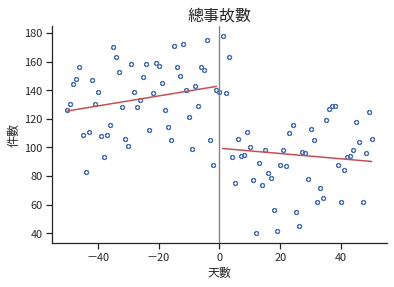

In [ ]:
traffic_all = TrafficRD(var_name='all_acc', df=df, title_name='總事故數')
traffic_all.run_model(modeltype='number')

### 超速(cause_speed)

                          PanelOLS Estimation Summary                           
Dep. Variable:            cause_speed   R-squared:                        0.0491
Estimator:                   PanelOLS   R-squared (Between):              0.0476
No. Observations:                 101   R-squared (Within):               0.0000
Date:                Wed, Jan 12 2022   R-squared (Overall):              0.0476
Time:                        02:24:51   Log-likelihood                   -199.23
Cov. Estimator:                Robust                                           
                                        F-statistic:                      1.5658
Entities:                         101   P-value                           0.2031
Avg Obs:                       1.0000   Distribution:                    F(3,91)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             2.0362
                            

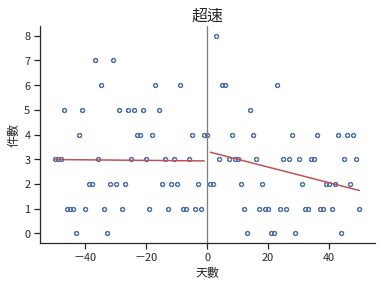

                          PanelOLS Estimation Summary                           
Dep. Variable:            cause_speed   R-squared:                        0.0538
Estimator:                   PanelOLS   R-squared (Between):              0.0446
No. Observations:                 101   R-squared (Within):               0.0000
Date:                Wed, Jan 12 2022   R-squared (Overall):              0.0446
Time:                        02:24:51   Log-likelihood                   -187.33
Cov. Estimator:                Robust                                           
                                        F-statistic:                      1.7260
Entities:                         101   P-value                           0.1672
Avg Obs:                       1.0000   Distribution:                    F(3,91)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             1.3944
                            

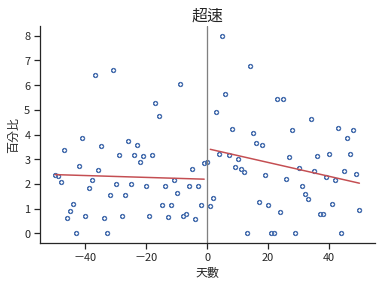

In [ ]:
traffic_speed = TrafficRD(var_name='cause_speed', df=df, title_name='超速')
traffic_speed.run_model(modeltype='number')
traffic_speed.run_model(modeltype='fraction')

### 警方到場花費時間(time_for_arrival)

                          PanelOLS Estimation Summary                           
Dep. Variable:       time_for_arrival   R-squared:                        0.0010
Estimator:                   PanelOLS   R-squared (Between):              0.0018
No. Observations:                 101   R-squared (Within):               0.0000
Date:                Sun, Jan 02 2022   R-squared (Overall):              0.0018
Time:                        05:41:05   Log-likelihood                   -459.58
Cov. Estimator:                Robust                                           
                                        F-statistic:                      0.0302
Entities:                         101   P-value                           0.9929
Avg Obs:                       1.0000   Distribution:                    F(3,91)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             0.0889
                            

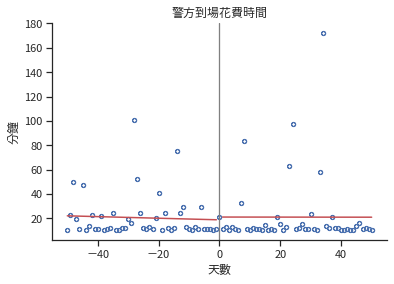

In [ ]:
traffic_time_for_arrival = TrafficRD(var_name='time_for_arrival', df=df, title_name='警方到場花費時間')
traffic_time_for_arrival.run_model(modeltype='fraction')

### 事件排除花費時間(time_for_solve)

                          PanelOLS Estimation Summary                           
Dep. Variable:         time_for_solve   R-squared:                        0.0372
Estimator:                   PanelOLS   R-squared (Between):              0.0384
No. Observations:                 101   R-squared (Within):               0.0000
Date:                Sun, Jan 02 2022   R-squared (Overall):              0.0384
Time:                        05:41:06   Log-likelihood                   -737.94
Cov. Estimator:                Robust                                           
                                        F-statistic:                      1.1729
Entities:                         101   P-value                           0.3245
Avg Obs:                       1.0000   Distribution:                    F(3,91)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             0.7685
                            

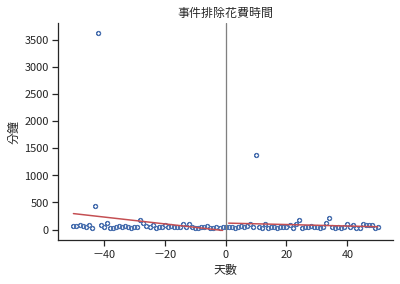

In [ ]:
traffic_time_for_solve = TrafficRD(var_name='time_for_solve', df=df, title_name='事件排除花費時間')
traffic_time_for_solve.run_model(modeltype='fraction')

### 交叉路口(intersection)

                          PanelOLS Estimation Summary                           
Dep. Variable:           intersection   R-squared:                        0.4899
Estimator:                   PanelOLS   R-squared (Between):              0.3381
No. Observations:                 101   R-squared (Within):               0.0000
Date:                Sun, Jan 02 2022   R-squared (Overall):              0.3381
Time:                        05:41:07   Log-likelihood                   -394.04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      29.127
Entities:                         101   P-value                           0.0000
Avg Obs:                       1.0000   Distribution:                    F(3,91)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             38.667
                            

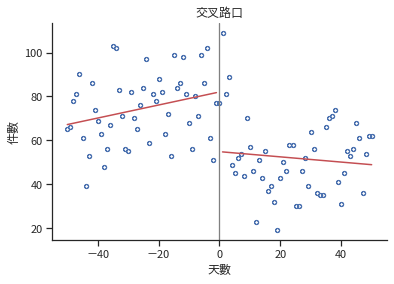

                          PanelOLS Estimation Summary                           
Dep. Variable:           intersection   R-squared:                        0.0530
Estimator:                   PanelOLS   R-squared (Between):              0.0492
No. Observations:                 101   R-squared (Within):               0.0000
Date:                Sun, Jan 02 2022   R-squared (Overall):              0.0492
Time:                        05:41:08   Log-likelihood                   -285.00
Cov. Estimator:                Robust                                           
                                        F-statistic:                      1.6970
Entities:                         101   P-value                           0.1732
Avg Obs:                       1.0000   Distribution:                    F(3,91)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             3.5139
                            

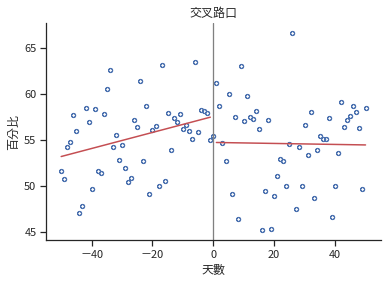

In [ ]:
traffic_intersection = TrafficRD(var_name='intersection', df=df, title_name='交叉路口')
traffic_intersection.run_model(modeltype='number')
traffic_intersection.run_model(modeltype='fraction')

### 路段中間(middleroad)

                          PanelOLS Estimation Summary                           
Dep. Variable:             middleroad   R-squared:                        0.5149
Estimator:                   PanelOLS   R-squared (Between):              0.3433
No. Observations:                 101   R-squared (Within):               0.0000
Date:                Sun, Jan 02 2022   R-squared (Overall):              0.3433
Time:                        05:41:08   Log-likelihood                   -349.12
Cov. Estimator:                Robust                                           
                                        F-statistic:                      32.200
Entities:                         101   P-value                           0.0000
Avg Obs:                       1.0000   Distribution:                    F(3,91)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             35.641
                            

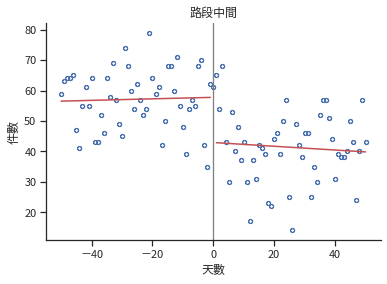

                          PanelOLS Estimation Summary                           
Dep. Variable:             middleroad   R-squared:                        0.0782
Estimator:                   PanelOLS   R-squared (Between):              0.0730
No. Observations:                 101   R-squared (Within):               0.0000
Date:                Sun, Jan 02 2022   R-squared (Overall):              0.0730
Time:                        05:41:09   Log-likelihood                   -282.74
Cov. Estimator:                Robust                                           
                                        F-statistic:                      2.5730
Entities:                         101   P-value                           0.0589
Avg Obs:                       1.0000   Distribution:                    F(3,91)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             4.6749
                            

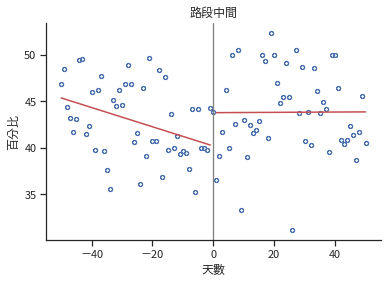

In [ ]:
traffic_middleroad = TrafficRD(var_name='middleroad', df=df, title_name='路段中間')
traffic_middleroad.run_model(modeltype='number')
traffic_middleroad.run_model(modeltype='fraction')

### 死亡人數(death_num)
24小時內、30天內都算

                          PanelOLS Estimation Summary                           
Dep. Variable:              death_num   R-squared:                        0.0785
Estimator:                   PanelOLS   R-squared (Between):              0.0775
No. Observations:                 101   R-squared (Within):               0.0000
Date:                Sun, Jan 02 2022   R-squared (Overall):              0.0775
Time:                        05:41:10   Log-likelihood                   -94.370
Cov. Estimator:                Robust                                           
                                        F-statistic:                      2.5853
Entities:                         101   P-value                           0.0580
Avg Obs:                       1.0000   Distribution:                    F(3,91)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             2.2929
                            

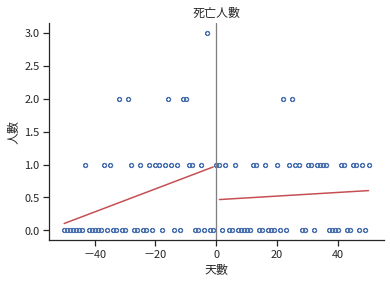

In [ ]:
traffic_death_num = TrafficRD(var_name='death_num', df=df, title_name='死亡人數')
traffic_death_num.run_model(modeltype='number')

### 死亡案件(fatal)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  fatal   R-squared:                        0.0739
Estimator:                   PanelOLS   R-squared (Between):              0.0727
No. Observations:                 101   R-squared (Within):               0.0000
Date:                Sun, Jan 02 2022   R-squared (Overall):              0.0727
Time:                        05:41:11   Log-likelihood                   -90.092
Cov. Estimator:                Robust                                           
                                        F-statistic:                      2.4189
Entities:                         101   P-value                           0.0713
Avg Obs:                       1.0000   Distribution:                    F(3,91)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             2.0367
                            

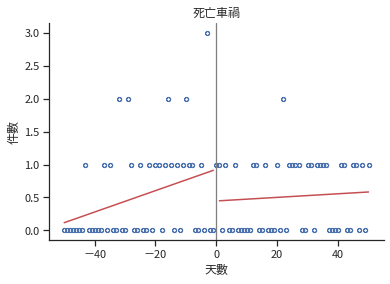

                          PanelOLS Estimation Summary                           
Dep. Variable:                  fatal   R-squared:                        0.0690
Estimator:                   PanelOLS   R-squared (Between):              0.0673
No. Observations:                 101   R-squared (Within):               0.0000
Date:                Sun, Jan 02 2022   R-squared (Overall):              0.0673
Time:                        05:41:12   Log-likelihood                   -92.269
Cov. Estimator:                Robust                                           
                                        F-statistic:                      2.2487
Entities:                         101   P-value                           0.0880
Avg Obs:                       1.0000   Distribution:                    F(3,91)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             3.5615
                            

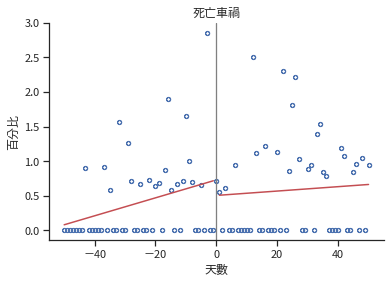

In [ ]:
traffic_fatal = TrafficRD(var_name='fatal', df=df, title_name='死亡車禍')
traffic_fatal.run_model(modeltype='number')
traffic_fatal.run_model(modeltype='fraction')

### 受傷人數(hurt_num)

                          PanelOLS Estimation Summary                           
Dep. Variable:               hurt_num   R-squared:                        0.5494
Estimator:                   PanelOLS   R-squared (Between):              0.3996
No. Observations:                 101   R-squared (Within):               0.0000
Date:                Sun, Jan 02 2022   R-squared (Overall):              0.3996
Time:                        05:41:12   Log-likelihood                   -469.53
Cov. Estimator:                Robust                                           
                                        F-statistic:                      36.978
Entities:                         101   P-value                           0.0000
Avg Obs:                       1.0000   Distribution:                    F(3,91)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             46.145
                            

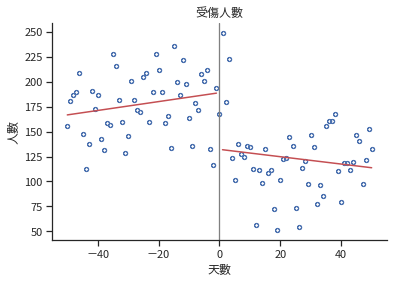

In [ ]:
traffic_hurt_num = TrafficRD(var_name='hurt_num', df=df, title_name='受傷人數')
traffic_hurt_num.run_model(modeltype='number')

## Driver Level

### 男性(male)

                          PanelOLS Estimation Summary                           
Dep. Variable:                   male   R-squared:                        0.5204
Estimator:                   PanelOLS   R-squared (Between):              0.3611
No. Observations:                 101   R-squared (Within):               0.0000
Date:                Sun, Jan 02 2022   R-squared (Overall):              0.3611
Time:                        05:41:13   Log-likelihood                   -399.00
Cov. Estimator:                Robust                                           
                                        F-statistic:                      32.910
Entities:                         101   P-value                           0.0000
Avg Obs:                       1.0000   Distribution:                    F(3,91)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             40.923
                            

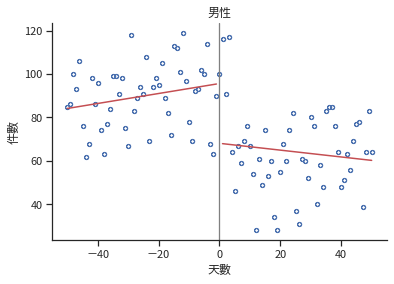

                          PanelOLS Estimation Summary                           
Dep. Variable:                   male   R-squared:                        0.0055
Estimator:                   PanelOLS   R-squared (Between):              0.0041
No. Observations:                 101   R-squared (Within):               0.0000
Date:                Sun, Jan 02 2022   R-squared (Overall):              0.0041
Time:                        05:41:14   Log-likelihood                   -292.35
Cov. Estimator:                Robust                                           
                                        F-statistic:                      0.1687
Entities:                         101   P-value                           0.9173
Avg Obs:                       1.0000   Distribution:                    F(3,91)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             0.2106
                            

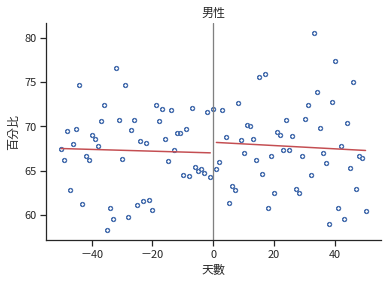

In [ ]:
traffic_male = TrafficRD(var_name='male', df=df, title_name='男性')
traffic_male.run_model(modeltype='number')
traffic_male.run_model(modeltype='fraction')

### 24歲以下(age_below_24)

                          PanelOLS Estimation Summary                           
Dep. Variable:           age_below_24   R-squared:                        0.4516
Estimator:                   PanelOLS   R-squared (Between):              0.3989
No. Observations:                 101   R-squared (Within):               0.0000
Date:                Sun, Jan 02 2022   R-squared (Overall):              0.3989
Time:                        05:41:15   Log-likelihood                   -325.04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      24.978
Entities:                         101   P-value                           0.0000
Avg Obs:                       1.0000   Distribution:                    F(3,91)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             29.557
                            

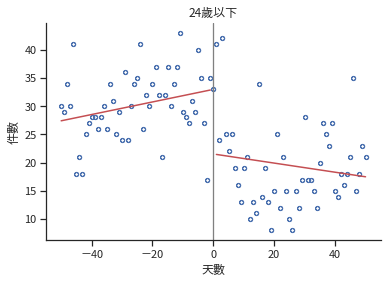

                          PanelOLS Estimation Summary                           
Dep. Variable:           age_below_24   R-squared:                        0.0715
Estimator:                   PanelOLS   R-squared (Between):              0.0609
No. Observations:                 101   R-squared (Within):               0.0000
Date:                Sun, Jan 02 2022   R-squared (Overall):              0.0609
Time:                        05:41:16   Log-likelihood                   -281.97
Cov. Estimator:                Robust                                           
                                        F-statistic:                      2.3352
Entities:                         101   P-value                           0.0791
Avg Obs:                       1.0000   Distribution:                    F(3,91)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             2.6586
                            

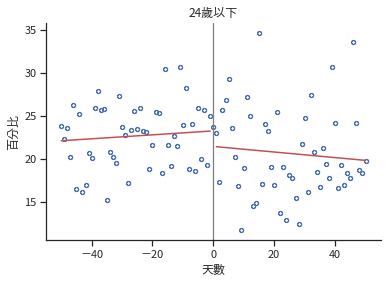

In [ ]:
traffic_age_below_24 = TrafficRD(var_name='age_below_24', df=df, title_name='24歲以下')
traffic_age_below_24.run_model(modeltype='number')
traffic_age_below_24.run_model(modeltype='fraction')

### 25歲至64歲(age_25_64)

                          PanelOLS Estimation Summary                           
Dep. Variable:              age_25_64   R-squared:                        0.5162
Estimator:                   PanelOLS   R-squared (Between):              0.3105
No. Observations:                 101   R-squared (Within):               0.0000
Date:                Sun, Jan 02 2022   R-squared (Overall):              0.3105
Time:                        05:41:17   Log-likelihood                   -398.10
Cov. Estimator:                Robust                                           
                                        F-statistic:                      32.360
Entities:                         101   P-value                           0.0000
Avg Obs:                       1.0000   Distribution:                    F(3,91)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             35.296
                            

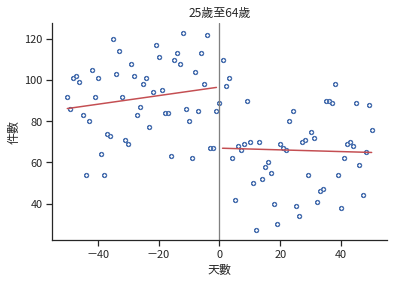

                          PanelOLS Estimation Summary                           
Dep. Variable:              age_25_64   R-squared:                        0.0469
Estimator:                   PanelOLS   R-squared (Between):              0.0434
No. Observations:                 101   R-squared (Within):               0.0000
Date:                Sun, Jan 02 2022   R-squared (Overall):              0.0434
Time:                        05:41:18   Log-likelihood                   -299.66
Cov. Estimator:                Robust                                           
                                        F-statistic:                      1.4923
Entities:                         101   P-value                           0.2219
Avg Obs:                       1.0000   Distribution:                    F(3,91)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             1.5396
                            

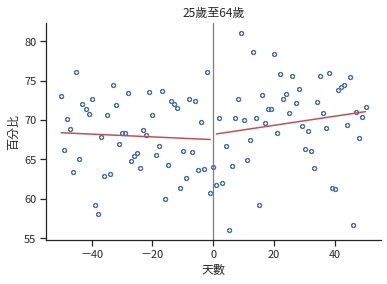

In [ ]:
traffic_age_25_64 = TrafficRD(var_name='age_25_64', df=df, title_name='25歲至64歲')
traffic_age_25_64.run_model(modeltype='number')
traffic_age_25_64.run_model(modeltype='fraction')

### 65歲以上(age_above_65)

                          PanelOLS Estimation Summary                           
Dep. Variable:           age_above_65   R-squared:                        0.1558
Estimator:                   PanelOLS   R-squared (Between):              0.1227
No. Observations:                 101   R-squared (Within):               0.0000
Date:                Sun, Jan 02 2022   R-squared (Overall):              0.1227
Time:                        05:41:18   Log-likelihood                   -284.70
Cov. Estimator:                Robust                                           
                                        F-statistic:                      5.5988
Entities:                         101   P-value                           0.0014
Avg Obs:                       1.0000   Distribution:                    F(3,91)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             7.1446
                            

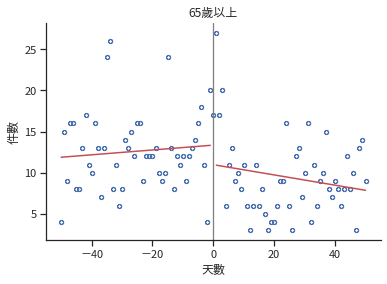

                          PanelOLS Estimation Summary                           
Dep. Variable:           age_above_65   R-squared:                        0.0135
Estimator:                   PanelOLS   R-squared (Between):              0.0134
No. Observations:                 101   R-squared (Within):               0.0000
Date:                Sun, Jan 02 2022   R-squared (Overall):              0.0134
Time:                        05:41:19   Log-likelihood                   -247.22
Cov. Estimator:                Robust                                           
                                        F-statistic:                      0.4147
Entities:                         101   P-value                           0.7429
Avg Obs:                       1.0000   Distribution:                    F(3,91)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             0.4251
                            

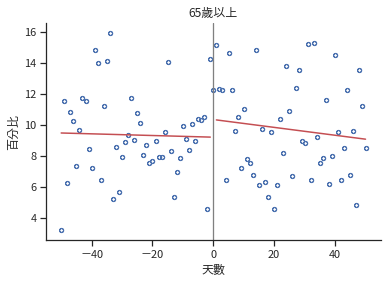

In [ ]:
traffic_age_above_65 = TrafficRD(var_name='age_above_65', df=df, title_name='65歲以上')
traffic_age_above_65.run_model(modeltype='number')
traffic_age_above_65.run_model(modeltype='fraction')

### 小客車(car)

                          PanelOLS Estimation Summary                           
Dep. Variable:                    car   R-squared:                        0.4827
Estimator:                   PanelOLS   R-squared (Between):              0.4152
No. Observations:                 101   R-squared (Within):               0.0000
Date:                Sun, Jan 02 2022   R-squared (Overall):              0.4152
Time:                        05:41:20   Log-likelihood                   -355.80
Cov. Estimator:                Robust                                           
                                        F-statistic:                      28.306
Entities:                         101   P-value                           0.0000
Avg Obs:                       1.0000   Distribution:                    F(3,91)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             30.341
                            

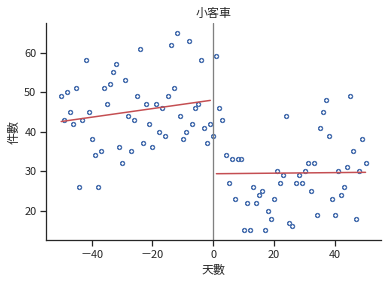

                          PanelOLS Estimation Summary                           
Dep. Variable:                    car   R-squared:                        0.0738
Estimator:                   PanelOLS   R-squared (Between):              0.0697
No. Observations:                 101   R-squared (Within):               0.0000
Date:                Sun, Jan 02 2022   R-squared (Overall):              0.0697
Time:                        05:41:20   Log-likelihood                   -304.75
Cov. Estimator:                Robust                                           
                                        F-statistic:                      2.4163
Entities:                         101   P-value                           0.0715
Avg Obs:                       1.0000   Distribution:                    F(3,91)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             2.5336
                            

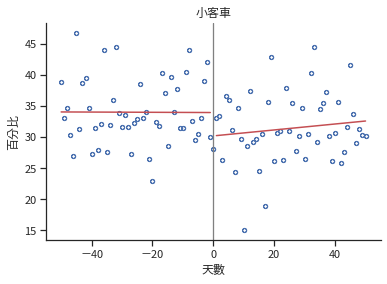

In [ ]:
traffic_car = TrafficRD(var_name='car', df=df, title_name='小客車')
traffic_car.run_model(modeltype='number')
traffic_car.run_model(modeltype='fraction')

### 機車(motor)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  motor   R-squared:                        0.4310
Estimator:                   PanelOLS   R-squared (Between):              0.2734
No. Observations:                 101   R-squared (Within):               0.0000
Date:                Sun, Jan 02 2022   R-squared (Overall):              0.2734
Time:                        05:41:21   Log-likelihood                   -387.85
Cov. Estimator:                Robust                                           
                                        F-statistic:                      22.981
Entities:                         101   P-value                           0.0000
Avg Obs:                       1.0000   Distribution:                    F(3,91)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             26.644
                            

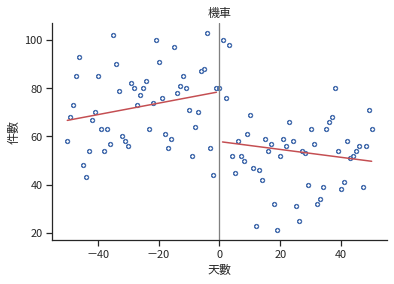

                          PanelOLS Estimation Summary                           
Dep. Variable:                  motor   R-squared:                        0.1052
Estimator:                   PanelOLS   R-squared (Between):              0.1049
No. Observations:                 101   R-squared (Within):               0.0000
Date:                Sun, Jan 02 2022   R-squared (Overall):              0.1049
Time:                        05:41:21   Log-likelihood                   -298.12
Cov. Estimator:                Robust                                           
                                        F-statistic:                      3.5646
Entities:                         101   P-value                           0.0172
Avg Obs:                       1.0000   Distribution:                    F(3,91)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             3.8731
                            

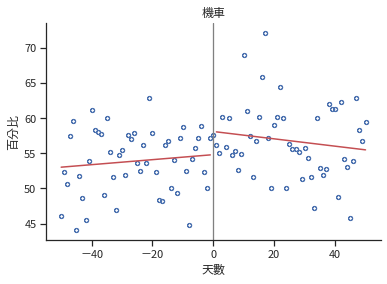

In [ ]:
traffic_motor = TrafficRD(var_name='motor', df=df, title_name='機車')
traffic_motor.run_model(modeltype='number')
traffic_motor.run_model(modeltype='fraction')

### 第一當事人喝酒(drunk)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  drunk   R-squared:                        0.1045
Estimator:                   PanelOLS   R-squared (Between):              0.0980
No. Observations:                 101   R-squared (Within):               0.0000
Date:                Sun, Jan 02 2022   R-squared (Overall):              0.0980
Time:                        05:41:21   Log-likelihood                   -183.20
Cov. Estimator:                Robust                                           
                                        F-statistic:                      3.5414
Entities:                         101   P-value                           0.0177
Avg Obs:                       1.0000   Distribution:                    F(3,91)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             3.3908
                            

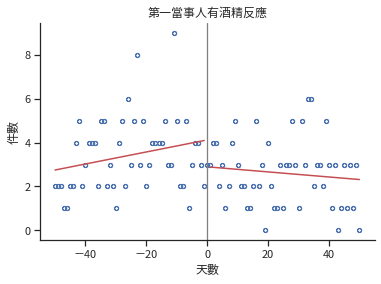

                          PanelOLS Estimation Summary                           
Dep. Variable:                  drunk   R-squared:                        0.0220
Estimator:                   PanelOLS   R-squared (Between):              0.0213
No. Observations:                 101   R-squared (Within):               0.0000
Date:                Sun, Jan 02 2022   R-squared (Overall):              0.0213
Time:                        05:41:22   Log-likelihood                   -189.30
Cov. Estimator:                Robust                                           
                                        F-statistic:                      0.6813
Entities:                         101   P-value                           0.5657
Avg Obs:                       1.0000   Distribution:                    F(3,91)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             1.0598
                            

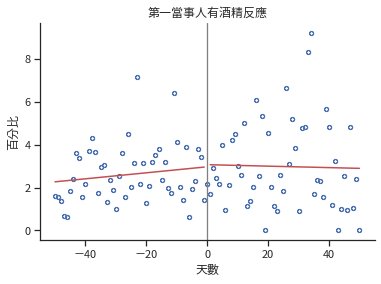

In [ ]:
traffic_drunk = TrafficRD(var_name='drunk', df=df, title_name='第一當事人有酒精反應')
traffic_drunk.run_model(modeltype='number')
traffic_drunk.run_model(modeltype='fraction')

### 第一當事人肇逃(hit_run)

                          PanelOLS Estimation Summary                           
Dep. Variable:                hit_run   R-squared:                        0.1275
Estimator:                   PanelOLS   R-squared (Between):              0.1240
No. Observations:                 101   R-squared (Within):               0.0000
Date:                Sun, Jan 02 2022   R-squared (Overall):              0.1240
Time:                        05:41:22   Log-likelihood                   -189.20
Cov. Estimator:                Robust                                           
                                        F-statistic:                      4.4338
Entities:                         101   P-value                           0.0059
Avg Obs:                       1.0000   Distribution:                    F(3,91)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             3.4731
                            

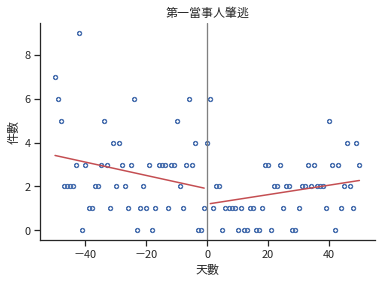

                          PanelOLS Estimation Summary                           
Dep. Variable:                hit_run   R-squared:                        0.0996
Estimator:                   PanelOLS   R-squared (Between):              0.0922
No. Observations:                 101   R-squared (Within):               0.0000
Date:                Sun, Jan 02 2022   R-squared (Overall):              0.0922
Time:                        05:41:23   Log-likelihood                   -176.87
Cov. Estimator:                Robust                                           
                                        F-statistic:                      3.3555
Entities:                         101   P-value                           0.0223
Avg Obs:                       1.0000   Distribution:                    F(3,91)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             3.2241
                            

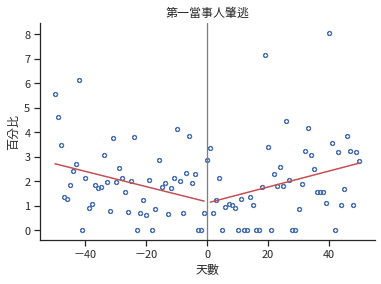

In [ ]:
traffic_hit_run = TrafficRD(var_name='hit_run', df=df, title_name='第一當事人肇逃')
traffic_hit_run.run_model(modeltype='number')
traffic_hit_run.run_model(modeltype='fraction')

# 繪圖

## 事故模型

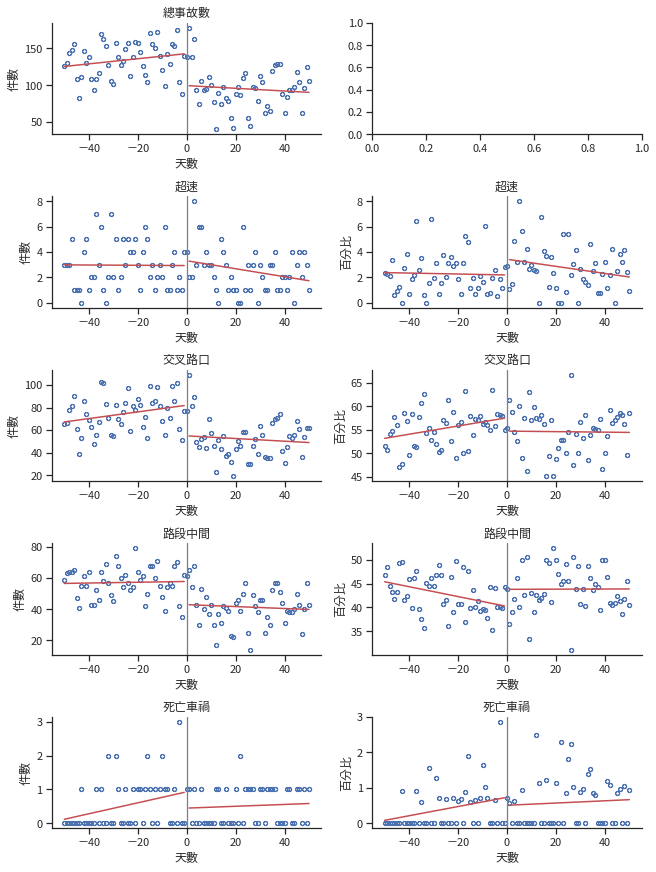

In [12]:
fig, axes = plt.subplots(5, 2, constrained_layout=True, figsize=(9,12))
varlist = ['all_acc', 'all_acc', 'cause_speed', 'cause_speed', 'intersection', 'intersection', 'middleroad', 'middleroad', 'fatal', 'fatal']
titlelist = ['總事故數', '總事故數', '超速', '超速', '交叉路口', '交叉路口', '路段中間', '路段中間', '死亡車禍', '死亡車禍']
for i, ax in enumerate(axes.flat):
    if i % 2 == 0:
        plotrd(ax, var_name=varlist[i], title_name=titlelist[i], modeltype='number')
    else:
        if i != 1:
            plotrd(ax, var_name=varlist[i], title_name=titlelist[i], modeltype='fraction')
# plt.suptitle('圖1: 事故模型')

## 第一當事人模型

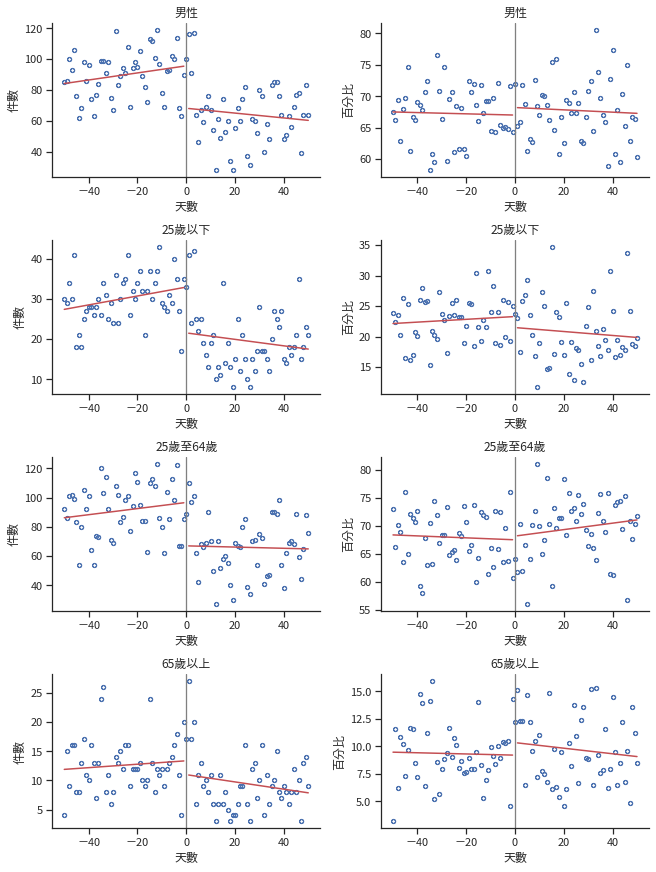

In [13]:
fig, axes = plt.subplots(4, 2, constrained_layout=True, figsize=(9,12))
varlist = ['male', 'male', 'age_below_24', 'age_below_24', 'age_25_64',
           'age_25_64', 'age_above_65', 'age_above_65']
titlelist = ['男性', '男性', '25歲以下', '25歲以下', '25歲至64歲',
             '25歲至64歲', '65歲以上', '65歲以上']
for i, ax in enumerate(axes.flat):
    if i % 2 == 0:
        plotrd(ax, var_name=varlist[i], title_name=titlelist[i], modeltype='number')
    else:
        plotrd(ax, var_name=varlist[i], title_name=titlelist[i], modeltype='fraction')
# plt.suptitle('圖2-1: 第一當事人模型')

Text(0.5, 0.98, '圖2-2: 第一當事人模型')

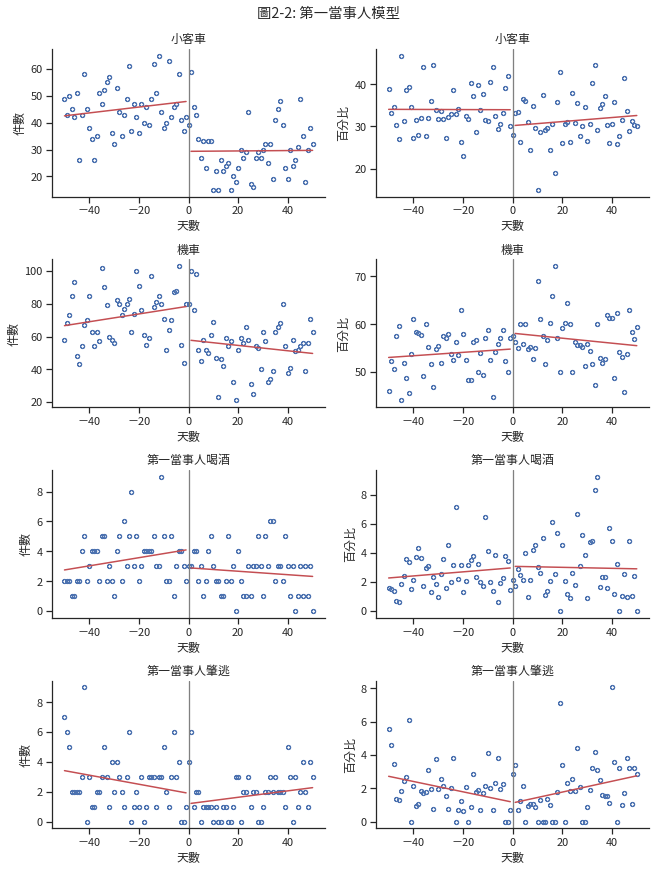

In [ ]:
⋯⋯fig, axes = plt.subplots(4, 2, constrained_layout=True, figsize=(9,12))
varlist = ['car', 'car', 'motor', 'motor', 'drunk',
           'drunk','hit_run', 'hit_run']
titlelist = ['小客車', '小客車', '機車', '機車', '第一當事人喝酒',
             '第一當事人喝酒', '第一當事人肇逃', '第一當事人肇逃']
for i, ax in enumerate(axes.flat):
    if i % 2 == 0:
        plotrd(ax, var_name=varlist[i], title_name=titlelist[i], modeltype='number')
    else:
        plotrd(ax, var_name=varlist[i], title_name=titlelist[i], modeltype='fraction')
plt.suptitle('圖2-2: 第一當事人模型')

## 其他

Text(0.5, 0.98, '圖3: 其他變數模型')

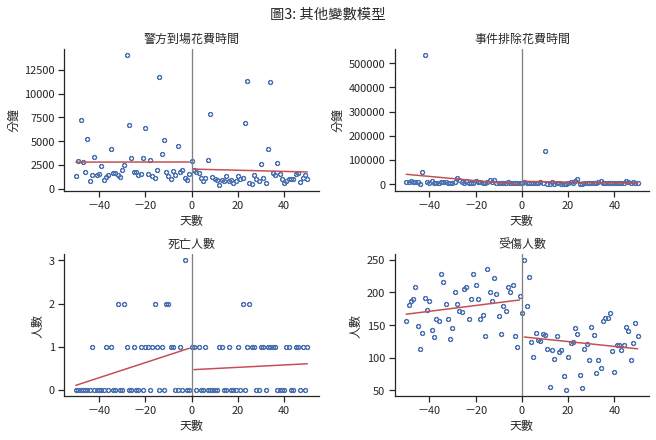

In [ ]:
fig, axes = plt.subplots(2, 2, constrained_layout=True, figsize=(9,6))
varlist = ['time_for_arrival', 'time_for_solve', 'death_num', 'hurt_num']
titlelist = ['警方到場花費時間', '事件排除花費時間', '死亡人數', '受傷人數']
for i, ax in enumerate(axes.flat):
    plotrd(ax, var_name=varlist[i], title_name=titlelist[i], modeltype='number')
plt.suptitle('圖3: 其他變數模型')